In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [2]:
@model function coin_model()
    
    a = datavar(Float64)
    b = datavar(Float64)
    y = datavar(Float64)
    
    θ ~ Beta(a, b)
    y ~ Bernoulli(θ)
    
    return y, a, b, θ
end

coin_model (generic function with 1 method)

In [8]:
N = 10000   # number of coin tosses
p = 0.5    # p parameter of the Bernoulli distribution

dataset = float.(rand(Bernoulli(p), N));

In [9]:
function inference(data)
    model, (y, a, b, θ) = coin_model()
    
    fe = ScoreActor(Float64)
    θs = keep(Marginal)
    
    fe_sub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    θ_sub = subscribe!(getmarginal(θ), θs)
    
    prior_sub = subscribe!(getmarginal(θ), (posterior) -> begin
        posterior_a, posterior_b = params(posterior)
        update!(a, posterior_a)
        update!(b, posterior_b)
    end)
    
    update!(a, 1.0)
    update!(b, 1.0)
    
    for d in data
        update!(y, d)
    end
    
    unsubscribe!(θ_sub)
    unsubscribe!(prior_sub)
    unsubscribe!(fe_sub)
    
    return getvalues(θs), getvalues(fe)
end

inference (generic function with 1 method)

In [10]:
est, fe = inference(dataset);

In [11]:
using Plots

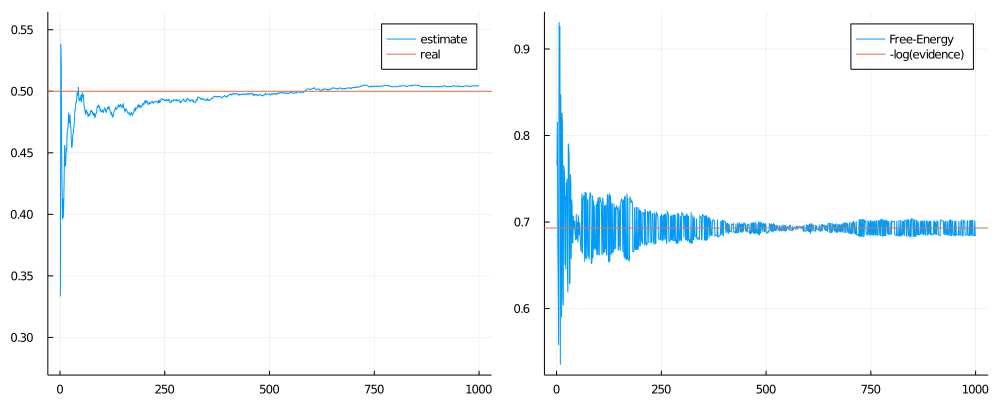

In [12]:
pest = est[1:10:end]
pfe = fe[1:10:end]

p1 = plot(mean.(pest), ribbon = var.(pest), label = "estimate")
p1 = plot!([ p ], seriestype = :hline, label = "real")
 
p2 = plot(pfe, label = "Free-Energy")
p2 = plot!([ -log(p) ], seriestype = :hline, label = "-log(evidence)")

plot(p1, p2, layout = @layout([ a b ]), size = (1000, 400))